# Experiment of Recurrent Neural Network in predicting the price movements of SP500

In [1]:
import pickle
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
# import quandl
import nltk
import itertools
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import collections
from sklearn.manifold import Isomap,MDS
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import sklearn
import statsmodels
yf.pdr_override()
import scipy.stats as scs
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import classification,confusion_matrix,matthews_corrcoef,accuracy_score,classification_report
from models.ffn_classifier import FFNClassifier
import scipy.stats as stats
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Price Data Preparation

In [2]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

In [3]:
lmap=lambda fun,it:list(map(lambda x:fun(x),it))

In [4]:
securities = pdr.get_data_yahoo(["SPY"], start="2005-01-01", end="2018-05-30")

[*********************100%***********************]  1 of 1 downloaded


In [5]:
class_number=2

In [6]:
data=securities['Adj Close'].fillna(method='ffill')
diff=(data.shift(-1)/data-1).fillna(0)
real_diff=data.shift(-1)-data.fillna(0)
labels=pd.qcut(diff,q=class_number,labels=range(class_number)).astype(int)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


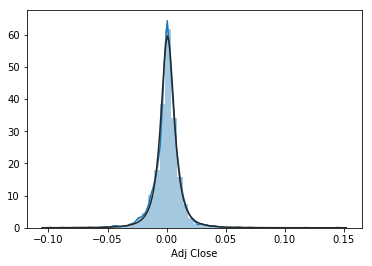

In [7]:
sns.distplot(diff,fit=stats.t)

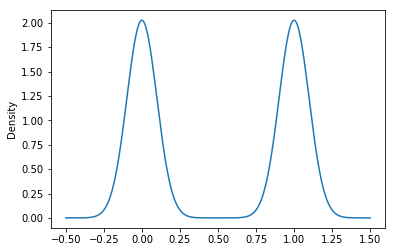

In [8]:
labels.plot(kind='kde')

## Define Test Function

In [11]:
def test(x,y,model,test_size=15,train_size=128,epoch=100, log_interval=10):
    train_loss=[]
    train_acc=[]
    train_mcc=[]
    dev_loss=[]
    dev_acc=[]
    dev_mcc=[]
    best_result=None
    best_score=0
    global_step=0
    best_result_epoch=0
    for e in tqdm_notebook(range(epoch)):
        pointer=0
        
        chunk_train_loss=0
        chunk_train_acc=0
        chunk_train_mcc=0
        train_count=0
        
        chunk_test_loss=0
        chunk_test_acc=0
        chunk_test_mcc=0
        test_count=0
        test_yhat=[]
        y_true=[]
        
        while pointer<len(x):
            
            train_x=x[pointer:pointer+train_size]
            train_y=y[pointer:pointer+train_size]
            train_length=len(train_x)
            b_pointer=0
            while b_pointer<train_length:
                random_batch_size=np.random.randint(low=32,high=128)
                batch_x=train_x[b_pointer:b_pointer+random_batch_size]
                batch_y=train_y[b_pointer:b_pointer+random_batch_size]
                loss,acc,mcc,_=model.train(X=batch_x,y=batch_y)
                chunk_train_loss+=loss
                chunk_train_acc+=acc
                chunk_train_mcc+=mcc
                b_pointer+=len(batch_x)
                pointer+=len(batch_x)
                global_step+=1
                train_count+=1
            if pointer>=len(x):
                break
            test_x=x[pointer:pointer+test_size]
            test_y=y[pointer:pointer+test_size]
            loss,acc,mcc,y_hat=model.test(X=test_x,y=test_y)
            test_yhat.append(y_hat)
            y_true.append(test_y)
            chunk_test_loss+=loss
            chunk_test_acc+=acc
            chunk_test_mcc+=mcc
            test_count+=1
            pointer+=len(test_x)
        chunk_train_loss=chunk_train_loss/train_count
        chunk_train_acc=chunk_train_acc/train_count
        chunk_train_mcc=chunk_train_mcc/train_count
        
        train_loss.append(chunk_train_loss)
        train_acc.append(chunk_train_acc)
        train_mcc.append(chunk_train_mcc)
        
        test_yhat=np.concatenate(test_yhat)
        y_true=np.concatenate(y_true)
        chunk_test_loss=chunk_test_loss/test_count
        chunk_test_acc=accuracy_score(y_pred=test_yhat,y_true=y_true)
        chunk_test_mcc=matthews_corrcoef(y_pred=test_yhat,y_true=y_true)
        
        if chunk_test_mcc+chunk_test_acc>best_score:
            best_result=test_yhat.copy()
            best_score=chunk_test_mcc+chunk_test_acc
            best_result_epoch=e
        
        
        dev_loss.append(chunk_test_loss)
        dev_acc.append(chunk_test_acc)
        dev_mcc.append(chunk_test_mcc)
        model.reset_model()
        if e%log_interval==0:
            print('test loss',dev_loss[-1],'test acc',dev_acc[-1],'test mcc',dev_mcc[-1],'epoch:',e)
            print('best_result_epoch',best_result_epoch,'acc',dev_acc[best_result_epoch],'mcc',dev_mcc[best_result_epoch])
    return np.array(train_loss),np.array(train_acc),np.array(train_mcc),np.array(dev_loss),np.array(dev_acc), np.array(dev_mcc), best_result,y_true.flatten()

In [12]:
def trade(a,price_diff,initial_price,test_size=15,train_size=128):
    pointer=0
    test_r=initial_price
    bnh_r=initial_price
    while pointer<len(x):
        pointer+=train_size
        if pointer>=len(x):
            break
        test_a=a[pointer:pointer+test_size]
        test_a=test_a*2-1
        test_p=price_diff[pointer:pointer+test_size]
        test_r+=(test_p*test_a).sum()
        bnh_r+=test_p.sum()
        pointer+=len(test_p)
    return test_r,bnh_r,test_r/initial_price,bnh_r/initial_price

In [28]:
# -*- coding:utf-8 -*-

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import sklearn
import numpy as np
import os


class RNN(nn.Module):
    def __init__(self, d_x, d_h, d_o, cell=nn.GRU, rnn_layers=2, ffn_layers=5, dp=0.5):
        super(RNN, self).__init__()
        self.dropout = nn.Dropout(p=dp)
        self.rnn_layers = rnn_layers
        self.rnn = cell(input_size=d_x, hidden_size=d_h, num_layers=rnn_layers, batch_first=True, dropout=dp)
        self.hiddens = nn.ModuleList([nn.Linear(in_features=d_h, out_features=d_h) for _ in range(ffn_layers)])
        self.lms = nn.ModuleList([nn.LayerNorm(d_h) for _ in range(ffn_layers)])
        self.f_out = nn.Linear(in_features=d_h, out_features=d_o)
        for p in self.rnn.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, x, hidden):
        x_in, hidden = self.rnn(x, hidden)
        output = x_in
        for hl, lm in zip(self.hiddens, self.lms):
            output = self.dropout(lm(F.leaky_relu(hl(output))))
        output = self.f_out(x_in + output)
        return output, hidden


class RNNClassifier(object):
    def __init__(self, d_x, d_h, d_o, rnn_layers=2, ffn_layers=5, lr=1e-3, cell=nn.GRU, dp=0.5):
        super(RNNClassifier, self).__init__()
        self.d_h = d_h
        self.rnn_layers = rnn_layers
        self.cell = cell
        self.rnn = RNN(d_x=d_x, d_h=d_h, d_o=d_o, rnn_layers=rnn_layers, ffn_layers=ffn_layers, cell=cell, dp=dp)
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.rnn.parameters(), lr=lr)
        if self.cell == nn.GRU:
            self.tmp_hidden = torch.zeros(self.rnn_layers, 1, d_h)
        elif self.cell == nn.LSTM:
            self.tmp_hidden = (torch.zeros(self.rnn_layers, 1, d_h), torch.zeros(self.rnn_layers, 1, d_h))
    
    def reset_model(self):
        if self.cell == nn.GRU:
            self.tmp_hidden = torch.zeros(self.rnn_layers, 1, self.d_h)
        elif self.cell == nn.LSTM:
            self.tmp_hidden = (torch.zeros(self.rnn_layers, 1, self.d_h), torch.zeros(self.rnn_layers, 1, self.d_h))
    
    def train(self, X, y):
        x = torch.tensor(X[None, :, :], dtype=torch.float32)
        y_true = torch.tensor(y, dtype=torch.long)
        self.rnn.train(True)
        self.optimizer.zero_grad()
        y_hat, self.tmp_hidden = self.rnn(x, hidden=self.tmp_hidden)
        y_hat=y_hat.squeeze(0)
        loss = self.loss_func(y_hat, y_true)
        loss.backward()
        clip_grad_norm_(self.rnn.parameters(), 1)
        self.optimizer.step()
        topv, topi = y_hat.topk(1)
        y_hat = topi.view(-1).detach()
        if type(self.tmp_hidden) == tuple:
            self.tmp_hidden = tuple([h.detach() for h in self.tmp_hidden])
        else:
            self.tmp_hidden= self.tmp_hidden.detach()
        acc = sklearn.metrics.accuracy_score(y_true=y.flatten(), y_pred=y_hat)
        mcc = sklearn.metrics.matthews_corrcoef(y_true=y.flatten(), y_pred=y_hat)
        return loss.item(), acc, mcc, y_hat.numpy().flatten()
    
    def test(self, X, y):
        self.rnn.eval()
        with torch.no_grad():
            x = torch.tensor(X[None, :, :], dtype=torch.float32)
            y_true = torch.tensor(y, dtype=torch.long)
            y_hat, self.tmp_hidden = self.rnn(x, hidden=self.tmp_hidden)
            y_hat=y_hat.squeeze(0)
            loss = self.loss_func(y_hat, y_true)
            topv, topi = y_hat.topk(1)
            y_hat = topi.view(-1)
            acc = sklearn.metrics.accuracy_score(y_true=y.flatten(), y_pred=y_hat)
            mcc = sklearn.metrics.matthews_corrcoef(y_true=y.flatten(), y_pred=y_hat)
            return loss.item(), acc, mcc, y_hat.numpy().flatten()
    
    def inference(self, X):
        self.rnn.eval()
        with torch.no_grad():
            x = torch.tensor(X[None, :, :], dtype=torch.float32)
            y_hat, self.tmp_hidden = self.rnn(x, hidden=self.tmp_hidden)
            y_hat=y_hat.squeeze(0)
            y_hat = y_hat.topk(1)[1].view(-1)
            return y_hat.numpy().flatten()
    
    def load_model(self, model_path='./RNNModel'):
        self.rnn = torch.load(model_path + '/model.pkl')
    
    def save_model(self, model_path='./RNNModel'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        torch.save(self.rnn, model_path + '/model.pkl')

### Experiment of pre-trained elmo encoded title, (mean with date)

In [29]:
reset_seed(1)

Each news title is a vector produced by mean of Elmo representation

In [15]:
date_index=np.load('data/title_elmo_index.npy')
content=np.load('data/title_elmo.npy')
content=pd.DataFrame(content,index=date_index)
content=content.groupby(content.index).mean()
content=content.join(labels).fillna(method='bfill').dropna()['2010-06':]

In [16]:
x=content.iloc[:,:-1].values
y=content.iloc[:,-1].values

In [30]:
clf=RNNClassifier(d_x=x.shape[-1],d_h=300,d_o=class_number,dp=0.5,ffn_layers=5,lr=1e-3,cell=nn.GRU,rnn_layers=2)

In [31]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,test_y=test(model=clf,x=x,y=y,test_size=15,train_size=150,epoch=100,log_interval=5)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


test loss 0.8025929717456594 test acc 0.5411764705882353 test mcc 0.07709015273959047 epoch: 0
best_result_epoch 0 acc 0.5411764705882353 mcc 0.07709015273959047
test loss 0.694995171883527 test acc 0.5411764705882353 test mcc 0.07398404914154026 epoch: 5
best_result_epoch 0 acc 0.5411764705882353 mcc 0.07709015273959047
test loss 0.6940658618422115 test acc 0.5137254901960784 test mcc 0.024074074074074074 epoch: 10
best_result_epoch 9 acc 0.5450980392156862 mcc 0.08703703703703704
test loss 0.6979085943278145 test acc 0.5333333333333333 test mcc 0.05728267726493279 epoch: 15
best_result_epoch 9 acc 0.5450980392156862 mcc 0.08703703703703704
test loss 0.7138184694682851 test acc 0.4549019607843137 test mcc -0.08703703703703704 epoch: 20
best_result_epoch 9 acc 0.5450980392156862 mcc 0.08703703703703704
test loss 0.6998851965455448 test acc 0.4980392156862745 test mcc -0.022243256038783615 epoch: 25
best_result_epoch 9 acc 0.5450980392156862 mcc 0.08703703703703704
test loss 0.697339327

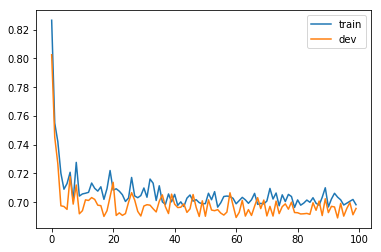

In [32]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

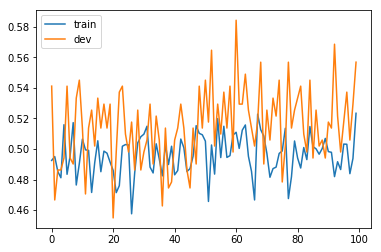

In [33]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

In [34]:
elmo_cr=classification_report(y_pred=best_result,y_true=test_y)
elmo_c=confusion_matrix(y_pred=best_result,y_true=test_y)
elmo_acc=accuracy_score(y_pred=best_result,y_true=test_y)
elmo_mcc=matthews_corrcoef(y_pred=best_result,y_true=test_y)

In [35]:
elmo_acc

0.5843137254901961

In [36]:
elmo_mcc

0.16236882817719775

In [37]:
elmo_c

array([[87, 48],
       [58, 62]])

In [38]:
print(elmo_cr)

              precision    recall  f1-score   support

         0.0       0.60      0.64      0.62       135
         1.0       0.56      0.52      0.54       120

   micro avg       0.58      0.58      0.58       255
   macro avg       0.58      0.58      0.58       255
weighted avg       0.58      0.58      0.58       255



### Experiment of d2v encoded title, (mean with date)

In [39]:
reset_seed(1)

In [40]:
date_index=np.load('data/title_d2v_index.npy')
content=np.load('data/title_d2v.npy')
content=pd.DataFrame(content,index=date_index)
content=content.groupby(content.index).mean()
content=content.join(labels).fillna(method='bfill').dropna()['2010-06':]

In [41]:
x=content.iloc[:,:-1].values
y=content.iloc[:,-1].values

In [42]:
clf=RNNClassifier(d_x=x.shape[-1],d_h=300,d_o=class_number,dp=0.5,ffn_layers=5,lr=1e-3,cell=nn.GRU,rnn_layers=2)

In [43]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,test_y=test(model=clf,x=x,y=y,test_size=15,train_size=150,epoch=100,log_interval=5)

test loss 0.8002231997602126 test acc 0.4745098039215686 test mcc -0.041318652453394146 epoch: 0
best_result_epoch 0 acc 0.4745098039215686 mcc -0.041318652453394146
test loss 0.6897053052397335 test acc 0.5176470588235295 test mcc 0.02796483563391768 epoch: 5
best_result_epoch 4 acc 0.5215686274509804 mcc 0.027078746481997443
test loss 0.6998213739956126 test acc 0.47843137254901963 test mcc -0.04344349577349724 epoch: 10
best_result_epoch 9 acc 0.5215686274509804 mcc 0.04724555912615341
test loss 0.7020938852254082 test acc 0.5176470588235295 test mcc 0.02622219463244465 epoch: 15
best_result_epoch 9 acc 0.5215686274509804 mcc 0.04724555912615341
test loss 0.7722635304226595 test acc 0.4627450980392157 test mcc -0.06878654392272061 epoch: 20
best_result_epoch 17 acc 0.5294117647058824 mcc 0.04129955231527934
test loss 0.7073346937403959 test acc 0.5058823529411764 test mcc 0.007415192869751505 epoch: 25
best_result_epoch 22 acc 0.5215686274509804 mcc 0.04922624211082283
test loss 0.7

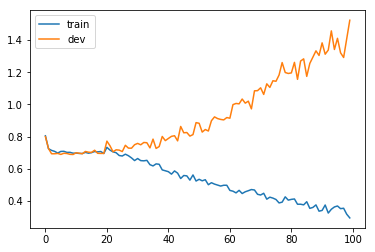

In [44]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

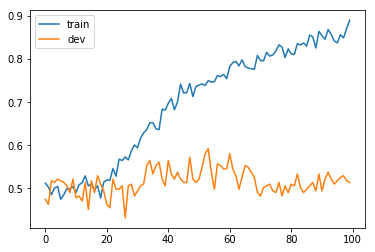

In [45]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

In [46]:
d2vc_cr=classification_report(y_pred=best_result,y_true=test_y)
d2vc_c=confusion_matrix(y_pred=best_result,y_true=test_y)
d2vc_acc=accuracy_score(y_pred=best_result,y_true=test_y)
d2vc_mcc=matthews_corrcoef(y_pred=best_result,y_true=test_y)

In [47]:
d2vc_acc

0.592156862745098

In [48]:
d2vc_mcc

0.1814814814814815

In [49]:
d2vc_c

array([[83, 52],
       [52, 68]])

In [50]:
print(d2vc_cr)

              precision    recall  f1-score   support

         0.0       0.61      0.61      0.61       135
         1.0       0.57      0.57      0.57       120

   micro avg       0.59      0.59      0.59       255
   macro avg       0.59      0.59      0.59       255
weighted avg       0.59      0.59      0.59       255



### Experiment of d2v encoded content, (mean with date)

In [51]:
reset_seed(1)

In [52]:
date_index=np.load('data/content_d2v_index.npy')
content=np.load('data/content_d2v.npy')
content=pd.DataFrame(content,index=date_index)
content=content.groupby(content.index).mean()
content=content.join(labels).fillna(method='bfill').dropna()['2010-06':]

In [53]:
x=content.iloc[:,:-1].values
y=content.iloc[:,-1].values

In [54]:
clf=RNNClassifier(d_x=x.shape[-1],d_h=300,d_o=class_number,dp=0.5,ffn_layers=5,lr=1e-3,cell=nn.GRU,rnn_layers=2)

In [55]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,test_y=test(model=clf,x=x,y=y,test_size=15,train_size=150,epoch=100,log_interval=5)

test loss 0.7979823666460374 test acc 0.4627450980392157 test mcc -0.0955050477812663 epoch: 0
best_result_epoch 0 acc 0.4627450980392157 mcc -0.0955050477812663
test loss 0.6938078263226677 test acc 0.5215686274509804 test mcc 0.027078746481997443 epoch: 5
best_result_epoch 5 acc 0.5215686274509804 mcc 0.027078746481997443
test loss 0.7009051722638747 test acc 0.4549019607843137 test mcc -0.09248988308500374 epoch: 10
best_result_epoch 8 acc 0.5372549019607843 mcc 0.0712962962962963
test loss 0.6993202567100525 test acc 0.5372549019607843 test mcc 0.06488998880388966 epoch: 15
best_result_epoch 8 acc 0.5372549019607843 mcc 0.0712962962962963
test loss 0.704559838070589 test acc 0.49411764705882355 test mcc -0.029905621022416718 epoch: 20
best_result_epoch 8 acc 0.5372549019607843 mcc 0.0712962962962963
test loss 0.6925613599665025 test acc 0.5372549019607843 test mcc 0.06488998880388966 epoch: 25
best_result_epoch 8 acc 0.5372549019607843 mcc 0.0712962962962963
test loss 0.70979014564

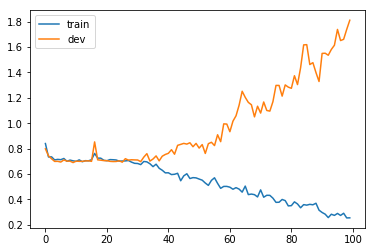

In [56]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

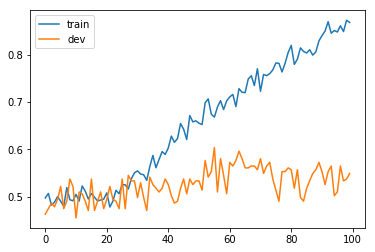

In [57]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

In [58]:
d2vt_cr=classification_report(y_pred=best_result,y_true=test_y)
d2vt_c=confusion_matrix(y_pred=best_result,y_true=test_y)
d2vt_acc=accuracy_score(y_pred=best_result,y_true=test_y)
d2vt_mcc=matthews_corrcoef(y_pred=best_result,y_true=test_y)

In [59]:
print(d2vt_cr)

              precision    recall  f1-score   support

         0.0       0.66      0.53      0.58       135
         1.0       0.56      0.69      0.62       120

   micro avg       0.60      0.60      0.60       255
   macro avg       0.61      0.61      0.60       255
weighted avg       0.61      0.60      0.60       255



In [60]:
d2vt_c

array([[71, 64],
       [37, 83]])

In [61]:
d2vt_acc

0.6039215686274509

In [62]:
d2vt_mcc

0.21980171108311994

### Experiment of RNN auto-encoder encoded title, (mean with date)

In [63]:
reset_seed(1)

In [64]:
date_index=np.load('data/title_ae_index.npy')
content=np.load('data/title_ae.npy')
content=pd.DataFrame(content,index=date_index)
content=content.groupby(content.index).mean()
content=content.join(labels).fillna(method='bfill').dropna()['2010-06':]

In [65]:
x=content.iloc[:,:-1].values
y=content.iloc[:,-1].values

In [66]:
clf=RNNClassifier(d_x=x.shape[-1],d_h=300,d_o=class_number,dp=0.5,ffn_layers=5,lr=1e-3,cell=nn.GRU,rnn_layers=2)

In [67]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,test_y=test(model=clf,x=x,y=y,test_size=15,train_size=150,epoch=100,log_interval=5)

test loss 0.830781473832972 test acc 0.4627450980392157 test mcc -0.0656425925209034 epoch: 0
best_result_epoch 0 acc 0.4627450980392157 mcc -0.0656425925209034
test loss 0.6936220526695251 test acc 0.5137254901960784 test mcc 0.024074074074074074 epoch: 5
best_result_epoch 3 acc 0.5450980392156862 mcc 0.06973018138246544
test loss 0.6993326544761658 test acc 0.5019607843137255 test mcc -0.006573421981221796 epoch: 10
best_result_epoch 3 acc 0.5450980392156862 mcc 0.06973018138246544
test loss 0.6960625858867869 test acc 0.5098039215686274 test mcc 0.010301576462746112 epoch: 15
best_result_epoch 3 acc 0.5450980392156862 mcc 0.06973018138246544
test loss 0.7103335997637581 test acc 0.4745098039215686 test mcc -0.05462962962962963 epoch: 20
best_result_epoch 3 acc 0.5450980392156862 mcc 0.06973018138246544
test loss 0.6998115252046024 test acc 0.5137254901960784 test mcc 0.010638078975070424 epoch: 25
best_result_epoch 3 acc 0.5450980392156862 mcc 0.06973018138246544
test loss 0.6959061

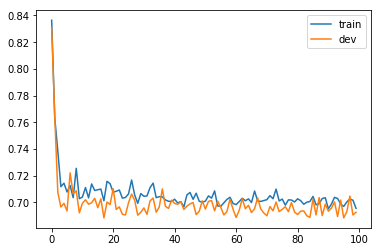

In [68]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

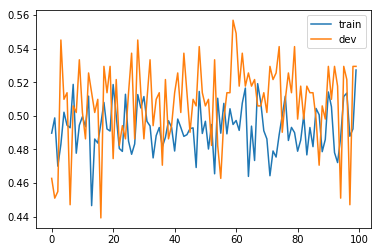

In [69]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

In [70]:
aet_cr=classification_report(y_pred=best_result,y_true=test_y)
aet_c=confusion_matrix(y_pred=best_result,y_true=test_y)
aet_acc=accuracy_score(y_pred=best_result,y_true=test_y)
aet_mcc=matthews_corrcoef(y_pred=best_result,y_true=test_y)

In [71]:
print(aet_cr)

              precision    recall  f1-score   support

         0.0       0.56      0.75      0.64       135
         1.0       0.55      0.34      0.42       120

   micro avg       0.56      0.56      0.56       255
   macro avg       0.55      0.54      0.53       255
weighted avg       0.55      0.56      0.54       255



In [72]:
aet_c

array([[101,  34],
       [ 79,  41]])

In [73]:
aet_acc

0.5568627450980392

In [74]:
aet_mcc

0.0983872001444465

In [75]:
random_result=[]
for _ in range(50):
    random_y=np.random.randint(low=0,high=2,size=test_y.shape[0])
    random_result.append([accuracy_score(y_pred=random_y,y_true=test_y),matthews_corrcoef(y_pred=random_y,y_true=test_y)])

In [76]:
np.save('results/ci_random',np.array(random_result))

### 2.3 Experiment of pure Glove word embedding titles (mean with each title, mean with date)

In [77]:
reset_seed(1)

In [78]:
date_index=np.load('data/title_glove_index.npy')
content=np.load('data/title_glove.npy')
content=pd.DataFrame(content,index=date_index)
content=content.groupby(content.index).mean()
content=content.join(labels).fillna(method='bfill').dropna()['2010-06':]

In [79]:
x=content.iloc[:,:-1].values
y=content.iloc[:,-1].values

In [80]:
clf=RNNClassifier(d_x=x.shape[-1],d_h=300,d_o=class_number,dp=0.5,ffn_layers=5,lr=1e-3,cell=nn.GRU,rnn_layers=2)

In [81]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,test_y=test(model=clf,x=x,y=y,test_size=15,train_size=150,epoch=100,log_interval=5)

test loss 0.7653453279944027 test acc 0.49411764705882355 test mcc -0.039557740264261995 epoch: 0
best_result_epoch 0 acc 0.49411764705882355 mcc -0.039557740264261995
test loss 0.6928008374045876 test acc 0.5137254901960784 test mcc 0.01154854529249894 epoch: 5
best_result_epoch 4 acc 0.5137254901960784 mcc 0.024074074074074074
test loss 0.7061117887496948 test acc 0.4196078431372549 test mcc -0.1749208393843982 epoch: 10
best_result_epoch 9 acc 0.5607843137254902 mcc 0.10928208401663254
test loss 0.707423045354731 test acc 0.47843137254901963 test mcc -0.05669750589755439 epoch: 15
best_result_epoch 9 acc 0.5607843137254902 mcc 0.10928208401663254
test loss 0.7593716979026794 test acc 0.40784313725490196 test mcc -0.1830848681582802 epoch: 20
best_result_epoch 9 acc 0.5607843137254902 mcc 0.10928208401663254
test loss 0.7043640192817239 test acc 0.5254901960784314 test mcc 0.06415002990995841 epoch: 25
best_result_epoch 9 acc 0.5607843137254902 mcc 0.10928208401663254
test loss 0.731

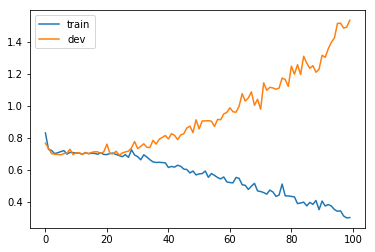

In [82]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

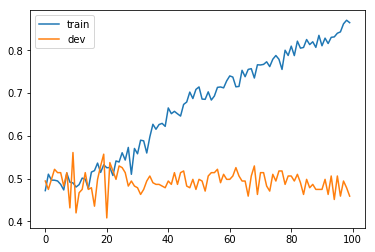

In [83]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

In [84]:
w2vt_cr=classification_report(y_pred=best_result,y_true=test_y)
w2vt_c=confusion_matrix(y_pred=best_result,y_true=test_y)
w2vt_acc=accuracy_score(y_pred=best_result,y_true=test_y)
w2vt_mcc=matthews_corrcoef(y_pred=best_result,y_true=test_y)

In [85]:
print(w2vt_cr)

              precision    recall  f1-score   support

         0.0       0.57      0.70      0.63       135
         1.0       0.54      0.41      0.47       120

   micro avg       0.56      0.56      0.56       255
   macro avg       0.56      0.55      0.55       255
weighted avg       0.56      0.56      0.55       255



In [86]:
w2vt_c

array([[94, 41],
       [71, 49]])

In [87]:
w2vt_acc

0.5607843137254902

In [88]:
w2vt_mcc

0.10928208401663254

In [89]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,use_xlable=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    yticks_axes=plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    if use_xlable:
        plt.xlabel('Predicted label')
    y_lable_axis=plt.ylabel('True label')

Confusion matrix, without normalization
[[71 64]
 [37 83]]
Confusion matrix, without normalization
[[83 52]
 [52 68]]
Confusion matrix, without normalization
[[101  34]
 [ 79  41]]
Confusion matrix, without normalization
[[94 41]
 [71 49]]
Confusion matrix, without normalization
[[87 48]
 [58 62]]


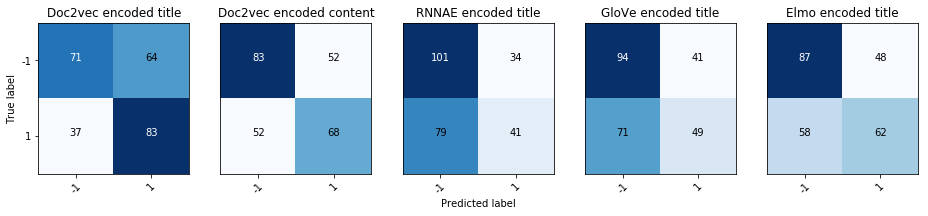

In [91]:
plt.figure(figsize=(13,3))
plt.title('Confusion Matrix for DNN Classifier')
ax1=plt.subplot2grid(shape=(1,5), loc=(0,0), colspan=1)
ax1.set_xlabel('')
plot_confusion_matrix(d2vt_c,classes=[-1,1],title='Doc2vec encoded title')
ax2=plt.subplot2grid((1,5), (0,1), colspan=1)
ax2.set_ylabel('')
ax2.yaxis.set_visible(False)
plot_confusion_matrix(d2vc_c,classes=[-1,1],title='Doc2vec encoded content')
ax3=plt.subplot2grid((1,5), (0,2), colspan=1)
ax3.set_ylabel('')
ax3.yaxis.set_visible(False)
plot_confusion_matrix(aet_c,classes=[-1,1],title='RNNAE encoded title',use_xlable=True)
ax4=plt.subplot2grid((1,5), (0,3), colspan=1)
ax4.set_ylabel('')
ax4.yaxis.set_visible(False)
plot_confusion_matrix(w2vt_c,classes=[-1,1],title='GloVe encoded title')
ax5 = plt.subplot2grid((1,5), (0,4), colspan=1)
ax5.set_ylabel('')
ax5.yaxis.set_visible(False)
plot_confusion_matrix(elmo_c,classes=[-1,1],title='Elmo encoded title')
# plt.colorbar()
plt.tight_layout()
plt.savefig('results/RNN_perf.pdf')